In [61]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.sparse import lil_matrix
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [62]:
Nx = 19
N = Nx**2
L = 1 ## mm
delta_x = L/(Nx+1)
delta_t = 0.01 ## sec
nu = 19 ## mm2/sec -> AIR
T  = 1 ## sec
it = T/delta_t
eps = 1e-4
## Boundary Conditions

u_bb = 4
u_rb = 0
u_tb = -5
u_lb = 0



c = nu*delta_t/(delta_x**2)
# Values for the diagonals
main_diag = (1+4*c) * np.ones(N)
lower_diag = -c * np.ones(N - 1)
upper_diag = -c * np.ones(N - 1)
upper_diag_2 = -c * np.ones(N-Nx)
lower_diag_2 = -c * np.ones(N-Nx)

# Create a sparse matrix (only 5 diagonals here)
A = diags(
    diagonals=[lower_diag_2,lower_diag, main_diag, upper_diag, upper_diag_2],
    offsets=[-Nx, -1, 0, 1, Nx],
    shape=(N, N),
    format='csr'
)

for i in range(Nx-1):
    A[(i+1)*(Nx-1),(i+1)*Nx] = 0
    A[(i+1)*Nx,(i+1)*(Nx-1)] = 0


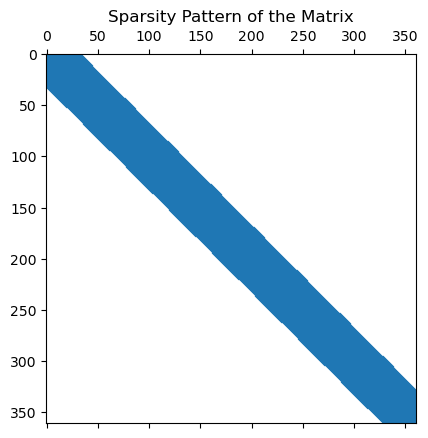

In [63]:
plt.spy(A, markersize=10)
plt.title("Sparsity Pattern of the Matrix")
plt.show()

In [64]:
b = np.zeros(N) # b vector , say U_0 = 0
# cells close to bottom boundary

def b_vector(bi, c, N, Nx, u_bb, u_rb, u_tb, u_lb):
    b = bi
    b[0:Nx] += c*u_bb ## eg-> b[1,1] + c*b[1,0]
    b[(Nx-1)*Nx:Nx*Nx] += c*u_tb ## eg -> b[1,4] + c*b[1,5]
    b[0:N:Nx] += c*u_lb ##
    b[Nx-1:N:Nx] += c*u_rb
    return b


In [65]:
b1 = b_vector(b, c, N, Nx, u_bb, u_rb, u_tb, u_lb)


In [66]:
def Conduction_solver_2d(A, eps, it):
    T  = np.zeros(N)
    bi = np.zeros(N)
    b  = np.zeros(N)
    residual_norm = 1
    residual = np.zeros(N)
    norm = []
    for i in range (it):
        if (residual_norm >= eps):
            b = b_vector(bi, c, N, Nx, u_bb, u_rb, u_tb, u_lb)
            #print(b)
            T = spsolve(A,b)
            residual = A@T - b
            residual_norm = np.linalg.norm(residual)
            norm.append(residual_norm)
            bi = T
            #print(i)
    return T, norm, b, i
        

In [67]:
T, norm, b, i = Conduction_solver_2d(A,eps=1e-15, it=1000)


In [68]:
A1 = np.zeros((Nx+2,Nx+2))
A1[0:Nx+1,0] += u_lb
A1[:,-1] += u_rb
A1[0,0:Nx+2] = u_bb 
A1[Nx+1,0:Nx+2] = u_tb
for i in range(Nx):
    A1[i+1,1:Nx+1] = T[(i)*Nx:(i+1)*Nx]

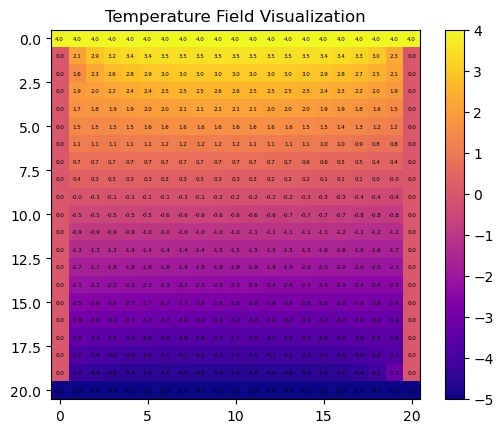

In [69]:
temperature_field = A1
plt.imshow(temperature_field, cmap='plasma', interpolation='nearest')
plt.colorbar()  # Color bar showing the temperature range
for i in range(temperature_field.shape[0]):  # Loop over rows
    for j in range(temperature_field.shape[1]):  # Loop over columns
        plt.text(j, i, f'{temperature_field[i, j]:.1f}', ha='center', va='center', color='black', fontsize = 4)

plt.title('Temperature Field Visualization')
plt.show()